## Helping Functions

In [3]:

import inspect
import os
import sys
# os.chdir('../')
# print(os.getcwd())
# if "experimental_copy_redo" in str(os.getcwd()):
#     os.chdir('../')
"""
    IMPORTING LIBS
"""
import dgl

import numpy as np
import os
import socket
import time
import random
import glob
import argparse, json
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader

from tensorboardX import SummaryWriter
from tqdm import tqdm

import random
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

import pandas as pd

import dgl.function as fn
MODEL_NAME = 'GraphSage'

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

"""
    IMPORTING CUSTOM MODULES/METHODS
"""
# from nets.COLLAB_edge_classification.load_net import gnn_model # import all GNNS
from nets.COLLAB_edge_classification.load_net import gnn_model
from data.data import LoadData
"""
    GPU Setup
"""
def gpu_setup(use_gpu, gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  

    if torch.cuda.is_available() and use_gpu:
#         print('cuda available with GPU:',torch.cuda.get_device_name(0))
        device = torch.device("cuda")
    else:
#         print('cuda not available')
        device = torch.device("cpu")
    return device
use_gpu = False; gpu_id = -1; device = None # CPU
# """
#     USER CONTROLS
# """

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def LoadData(APPLICATION_NAME):
    global EPOC_NUMBER

    df = pd.read_csv("../prune_new/"+APPLICATION_NAME+"_node.csv")
    # df = df.drop(["start_line","start_column","end_line",  "end_column" ,"file_name", "id"], axis=1)
    # EPOC_NUMBER = "238"
    return df    

In [5]:

def get_thresholds(PATH, EPOC_NUMBER):
    all_list =[[],[],[]]
    k=0
    with open(PATH+"/THRESHOLD/threshold_values_with_"+str(EPOC_NUMBER)+".txt") as in_file:
        for line in in_file:
            parts = line.split(" ")
            # print(parts)
            for part in parts:
                try:
                    numeric_string = float(''.join(c for c in part if (c.isdigit() or c =='.' or c=='e' or c=='-')))
                    # print(numeric_string)
                    all_list[k].append(numeric_string)
                except:
                    pass
            if "]" in line:
                k+=1

    threshold_lst = all_list[0]
    fpr_lst = all_list[1]
    tpr_lst = all_list[2]

    # print(threshold_lst)
    for i in range(len(fpr_lst)):
        if fpr_lst[i]!=0.0:
            first_index = i-1
            break
    # print(first_index)
    for i in range(len(tpr_lst)):
        if tpr_lst[i]>=.99:
            last_index = i
            break

    first_thrshld = threshold_lst[first_index]
    last_thrshld = threshold_lst[last_index]

    return first_thrshld, last_thrshld


In [6]:
def get_EPOC_Number(PATH):
    file_path = PATH+"/ROC_CURVE/*"
    project_list = glob.glob(file_path)
    max_ = -1
    for line in project_list:
        index = line.rfind("_")
        last_index = line.rfind(".png")
        number = int(line[index+1:last_index])
        max_ = max(max_, number)
    # print(max_)
    return max_

In [7]:
def get_file_name(src, APPLICATION_NAME):
    node_df_org = pd.read_csv("../prune_new/"+APPLICATION_NAME+"_node.csv")
    node_df = node_df_org[node_df_org['new_id']==src].reset_index(drop=True)
    file_name = node_df.iloc[0]['file_name']

    return file_name

In [8]:
def get_rank(PATH, APPLICATION_NAME):

    df = pd.read_csv(PATH)
    dst_dict = dict(df.values)
    main_lst = []
    lst = []
    with open("dynamic_"+APPLICATION_NAME+"_missing_edge_log_GatedGCN.txt", "r+") as in_file:
        for line in in_file:
            if len(line.strip())==0:
                temp_lst =[]
                for x in lst:
                    temp_lst.append(x)
                if len(temp_lst)>0:
                    main_lst.append(temp_lst)
                lst =[]
            else:
                lst.append(line)
        count = 0
        # print(len(main_lst))
        rank_lst =[]
        src_lst = []
        dst_lst =[]
        for lst in main_lst:
            node_lst = []
            pred_lst = []
            for line in lst:
                if "Total edge above" not in line and "RANK 1 number of edge" not in line:
                    if 'Source =====>' in line:
                        parts = line.split(" ")
                        src = int(parts[-1].strip())
                    else:
                        parts = line.split(" ")
                        # print(parts)
                        dst = int(parts[-3].strip())
                        value = float(parts[-1].strip())
                        # print(dst, value)
                        node_lst.append(dst)
                        pred_lst.append(value)
            
            result_df = pd.DataFrame(list(zip(node_lst, pred_lst)), columns =['id', 'val'])
            result_df = result_df.sort_values(by=['val'], ascending=False).reset_index(drop=True)
            
            if len(result_df)>0:
                TARGET = dst_dict[src]
                # first_index = result_df.iloc[0]['id']
                # # print(TARGET, first_index)
                # if first_index == TARGET:
                #     count+=1
                found = False
                for i in range(len(result_df)):
                    id = result_df.iloc[i]['id']
                    if id == TARGET:
                        src_lst.append(src)
                        dst_lst.append(TARGET)
                        rank_lst.append(i)
                        found = True

        # print(len(rank_lst))
        # print(len(src_lst), len(dst_lst))

        df = pd.DataFrame({'src':src_lst, 'dst':dst_lst,'rank':rank_lst})
        return df
        
   

In [9]:
# def get_df(PATH, APPLICATION_NAME):
#     from pandas import read_csv
#     pos_df = read_csv("../prune+bidirectional+semantic_edge+dynamic_edge/dynamic_edges/prune_dynamic_edges_"+APPLICATION_NAME+".csv")
#     pos_df = pos_df_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp.drop_duplicates().reset_index(drop=True)
#     pget_rank("../prune+bidirectional+semantic_edge+dynamic_edge/dynamic_edges/prune_dynamic_edges_"+APPLICATION_NAME+".csv", APPLICATION_NAME)
#     return pos_df

## STAT

In [10]:
ranking_count = 10
def get_count_dict(rank_lst):
    count_dict={}
    for i in range(0, ranking_count+2):
        count_dict[i] = 0
    xticks_list=[]
    for x in rank_lst:
        key = x
        if x >ranking_count:
            key = ranking_count+1
        count= count_dict[key]
        count_dict[key]=count+1
             
    # for x in range(21):
    #     xticks_list.append(str(x))
    # xticks_list.append('20+')
        
    count_dict = dict(sorted(count_dict.items()))
    print(count_dict)
    return list(count_dict.values())
    # import matplotlib.pyplot as plt
    # import seaborn as sns
    # try:
    #     plt.figure(figsize=(16, 8))
    #     categories = list(count_dict.keys())
    #     counts = list(count_dict.values())

    #     # Create a bar plot using Seaborn
    #     ax = sns.barplot(x=categories, y=counts)
    #     plt.xticks(range(len(xticks_list)), xticks_list)
    #     plt.title('Histogram of Candidate Ranking')
    #     plt.xlabel('Ranking')
    #     plt.ylabel('Count')
    #     plt.show()
    # except:
    #     pass

In [11]:
def plot_figure(count_dataframe, APPLICATION_NAME):
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(16, 8))
    sns.set(style='white')
    
    xticks_list=[]
    for x in range(4):
        xticks_list.append(str(x))
    xticks_list.append('4+')

    count_dataframe.set_index('category').plot(kind='bar', stacked=True)
    plt.xticks(range(len(xticks_list)), xticks_list)
    plt.title('Histogram of Candidate Ranking')
    plt.xlabel('Ranking')
    plt.ylabel('Count')
    plt.savefig("candidate_figures/stacked_bar"+APPLICATION_NAME+".pdf")
    # plt.close()
    # plt.show()

In [12]:
def getStatforPOS(pos_df, node_df, iv_function_df, APPLICATION_NAME):
    from torch import isin
    source=[]
    dst=[]
    src_lst=[]
    dst_lst=[]
    src_file_name_list =[]
    src_line_number_list=[]

    dst_file_name_list =[]
    dst_line_number_list=[]

    for i in range(len(pos_df)):
        tmp_df =pos_df.iloc[i]
        u = int(tmp_df[0])
        # print("u ====> ", u)
        u_node = node_df[node_df['new_id']==u]
        u_node_name = u_node['name'].iloc[0]

        file_name = u_node['file_name'].iloc[0]
        src_file_name_list.append(file_name)
        start_line = int(u_node['start_line'].iloc[0])
        src_line_number_list.append(start_line)
        
        v = int(tmp_df[1])
        v_node = node_df[node_df['new_id']==v]
        v_node_name = v_node['name'].iloc[0]
        # print(u, u_node_name,v ,v_node_name)

        file_name = v_node['file_name'].iloc[0]
        dst_file_name_list.append(file_name)
        start_line = int(v_node['start_line'].iloc[0])
        dst_line_number_list.append(start_line)

        source.append(u_node_name)
        dst.append(v_node_name)
    
    pos_df[3]=source
    pos_df[4]=dst
    pos_df[5]=src_file_name_list
    pos_df[6]=src_line_number_list
    pos_df[7]=dst_file_name_list
    pos_df[8]=dst_line_number_list
    
    x = [x for x in range(ranking_count+2)]
    count_dataframe = pd.DataFrame({'category':x})

    pos_df_temp = pos_df.dropna(subset=[3, 4])

    same_name_df = pos_df_temp[pos_df_temp[3]==pos_df_temp[4]]
    # print(len(same_name_df))
    same_name_and_file = pos_df_temp[(pos_df_temp[5]==pos_df_temp[7])& (pos_df_temp[3]==pos_df_temp[4])].reset_index(drop=True)
    # print(same_name_and_file)
    count_list = get_count_dict(same_name_and_file['rank'].tolist())
    print(count_list)
    count_dataframe['Same Name and File'] = count_list

    same_name_but_dufferent_file = pos_df_temp[(pos_df_temp[5]!=pos_df_temp[7])& (pos_df_temp[3]==pos_df_temp[4])].reset_index(drop=True)
    count_list = get_count_dict(same_name_but_dufferent_file['rank'].tolist())
    count_dataframe['Same Name But Different File'] = count_list

    different_name_df = same_name_df = pos_df_temp[pos_df_temp[3]!=pos_df_temp[4]]
    different_name_and_file = pos_df_temp[(pos_df_temp[5]!=pos_df_temp[7])& (pos_df_temp[3]!=pos_df_temp[4])].reset_index(drop=True)
    count_list = get_count_dict(different_name_and_file['rank'].tolist())
    count_dataframe['Different Name and File'] = count_list

    different_name_but_same_file = pos_df_temp[(pos_df_temp[5]==pos_df_temp[7])& (pos_df_temp[3]!=pos_df_temp[4])].reset_index(drop=True)
    count_list = get_count_dict(different_name_but_same_file['rank'].tolist())
    count_dataframe['Different Name But Same File'] = count_list
    
    
    # both_anonymus_functions = pos_df[((pd.isna(pos_df[3])) & (pd.isna(pos_df[4])))]
    # count_list = get_count_dict(both_anonymus_functions['rank'].tolist())
    # count_dataframe['Caller and Callee Both Anonymous Functions'] = count_list

    anonymus_functions = pos_df[(~(pd.isna(pos_df[3])) & (pd.isna(pos_df[4])))]
    count_list = get_count_dict(anonymus_functions['rank'].tolist())
    count_dataframe['Anonymous Functions'] = count_list

    iv_function_ids = iv_function_df['id'].tolist()
    # print(iv_function_ids)
    iv_function_df = pos_df[pos_df['src'].isin(iv_function_ids)]
    # print(iv_function_df)
    count_list = get_count_dict(iv_function_df['rank'].tolist())
    count_dataframe['Immediately invoked functions'] = count_list
    return count_dataframe, APPLICATION_NAME
    plot_figure(count_dataframe, APPLICATION_NAME)
    # import matplotlib.pyplot as plt
    # import seaborn as sns    
    # sns.set(style='white')
    # fig, ax = plt.subplots()
    # xticks_list=[]
    # for x in range(21):
    #     xticks_list.append(str(x))
    # xticks_list.append('20+')

    # count_dataframe.set_index('category').plot(kind='bar', stacked=True, ax=ax,figsize=(16,8))
    # plt.xticks(range(len(xticks_list)), xticks_list)
    # plt.title('Histogram of Candidate Ranking')
    # plt.xlabel('Ranking')
    # plt.ylabel('Count')
    # plt.savefig("candidate_figures/stacked_bar_"+APPLICATION_NAME+".pdf")

    
    

In [13]:
# def getStatforPOS(pos_df, thshld, node_df, iv_function_df, APPLICATION_NAME):
#     from torch import isin
#     source=[]
#     dst=[]
#     src_lst=[]
#     dst_lst=[]
#     src_file_name_list =[]
#     src_line_number_list=[]

#     dst_file_name_list =[]
#     dst_line_number_list=[]

#     for i in range(len(pos_df)):
#         tmp_df =pos_df.iloc[i]
#         u = int(tmp_df[0])
#         # print("u ====> ", u)
#         u_node = node_df[node_df['new_id']==u]
#         u_node_name = u_node['name'].iloc[0]

#         file_name = u_node['file_name'].iloc[0]
#         src_file_name_list.append(file_name)
#         start_line = int(u_node['start_line'].iloc[0])
#         src_line_number_list.append(start_line)
        
#         v = int(tmp_df[1])
#         v_node = node_df[node_df['new_id']==v]
#         v_node_name = v_node['name'].iloc[0]
#         # print(u, u_node_name,v ,v_node_name)

#         file_name = v_node['file_name'].iloc[0]
#         dst_file_name_list.append(file_name)
#         start_line = int(v_node['start_line'].iloc[0])
#         dst_line_number_list.append(start_line)

#         source.append(u_node_name)
#         dst.append(v_node_name)
    
#     pos_df[3]=source
#     pos_df[4]=dst
#     pos_df[5]=src_file_name_list
#     pos_df[6]=src_line_number_list
#     pos_df[7]=dst_file_name_list
#     pos_df[8]=dst_line_number_list
    
    
#     # anonymus_functions = pos_df[(~(pd.isna(pos_df[3])) & (pd.isna(pos_df[4])))].reset_index(drop=True)
#     # # # print(anonymus_functions)
#     # exclude = ['parse', 'o', 'setVariable','error', 'registerOperation','toNumber','isValidStrict', 'evaluateByOperator','func']
#     # exclude = []
#     # for i in range(len(anonymus_functions)):
#     #     if anonymus_functions.iloc[i][3] not in exclude and anonymus_functions.iloc[i]['rank']==0:
#     #         print(anonymus_functions.iloc[i][5]," =====> ",anonymus_functions.iloc[i][6], anonymus_functions.iloc[i][3], anonymus_functions.iloc[i]['rank']
#     #               ,anonymus_functions.iloc[i][7]," =====> ",anonymus_functions.iloc[i][8])


#     df = pos_df[pos_df[5].str.contains("evaluate-by-operator")].reset_index(drop=True)

#     for i in range(len(df)):
#         # if df.iloc[i][3] not in exclude and anonymus_functions.iloc[i]['rank']==1:
#         print(df.iloc[i][5]," =====> ",df.iloc[i][6], df.iloc[i][3], df.iloc[i]['rank']
#                   ,df.iloc[i][7]," =====> ",df.iloc[i][8])


#     # df = pos_df[pos_df['rank']==0].reset_index(drop=True)

#     # for i in range(len(df)):
#     #     if df.iloc[i][3] not in exclude:
#     #         print(df.iloc[i][5]," =====> ",df.iloc[i][6], df.iloc[i][3], df.iloc[i]['rank']
#     #                 ,df.iloc[i][7]," =====> ",df.iloc[i][8])

#     # print(df)
            
#     # count_list = get_count_dict(anonymus_functions['rank'].tolist())
#     # count_dataframe['Anonymous Functions'] = count_list

#     # iv_function_ids = iv_function_df['id'].tolist()
#     # # print(iv_function_ids)
#     # iv_function_df = pos_df[pos_df['src'].isin(iv_function_ids)]
#     # print(iv_function_df)
#     # count_list = get_count_dict(iv_function_df['rank'].tolist())
#     # count_dataframe['Immediately invoked functions'] = count_list
    
#     # # plot_figure(count_dataframe, APPLICATION_NAME)
#     # import matplotlib.pyplot as plt
#     # import seaborn as sns    
#     # sns.set(style='white')
#     # fig, ax = plt.subplots()
#     # xticks_list=[]
#     # for x in range(21):
#     #     xticks_list.append(str(x))
#     # xticks_list.append('20+')

#     # count_dataframe.set_index('category').plot(kind='bar', stacked=True, ax=ax,figsize=(16,8))
#     # plt.xticks(range(len(xticks_list)), xticks_list)
#     # plt.title('Histogram of Candidate Ranking')
#     # plt.xlabel('Ranking')
#     # plt.ylabel('Count')
#     # plt.savefig("candidate_figures/stacked_bar_"+APPLICATION_NAME+".pdf")

    
    

## Driver Function

In [44]:
if __name__ == "__main__":
    # MODEL_NAME = 'GAT'
    MODEL_NAME = 'GatedGCN'
    # EPOC_NUMBER = "132"

    to_do_list = ['formula-parser', 'lodash','express','js-yaml', 'mathjs']
    app_list =  ['formula-parser', 'lodash','express','js-yaml', 'mathjs']

    to_do_list = ['express']
    app_list =  ['express']
    
    for i in range(len(to_do_list)):
        APPLICATION_NAME = app_list[i]
        print("\033[97m ------------------------------------------------------------------")
        print("\033[97m ", APPLICATION_NAME)
        print("\033[97m ------------------------------------------------------------------")
        # print("[I] Loading data (notebook) ...")
        node_df = LoadData(APPLICATION_NAME=APPLICATION_NAME)
        # print(node_df)
        # print("[I] Finished loading.")
        PATH = "results/NEW_DATASET--"+APPLICATION_NAME+"/"+MODEL_NAME
        EPOC_NUMBER = get_EPOC_Number(PATH=PATH)
        print(EPOC_NUMBER)
        # first_thrshld, last_thrshld = get_thresholds(PATH=PATH, EPOC_NUMBER=EPOC_NUMBER)
        pos_df = get_rank("../prune+bidirectional+semantic_edge+dynamic_edge/dynamic_edges/prune_dynamic_edges_"+APPLICATION_NAME+".csv", APPLICATION_NAME)
        # df = pd.read_csv("../prune+bidirectional+semantic_edge+dynamic_edge/results/NEW_DATASET--"+APPLICATION_NAME+"/GatedGCN/POS_PRED/pred_score_with_0_pos.csv", header=None)
        # df.columns = ['src', 'dst', 'prob']
        # df = df.drop(['prob'], axis=1)
        # print(len(pos_df))
        # pos_df = pos_df.merge(df, indicator=True, how='inner').drop('_merge', axis=1)
        iv_function_df = pd.read_csv('id_files/'+APPLICATION_NAME+'_iv_function_ids.csv')
        count_dataframe, APPLICATION_NAME = getStatforPOS(pos_df, node_df, iv_function_df, APPLICATION_NAME)
        # getStatforNEG(neg_df, last_thrshld, node_df, iv_function_df)

# print(node_df)

 ------------------------------------------------------------------
  express
 ------------------------------------------------------------------
203
{0: 69, 1: 39, 2: 11, 3: 2, 4: 6, 5: 1, 6: 4, 7: 1, 8: 0, 9: 1, 10: 1, 11: 15}
[69, 39, 11, 2, 6, 1, 4, 1, 0, 1, 1, 15]
{0: 53, 1: 10, 2: 15, 3: 0, 4: 4, 5: 2, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 54}
{0: 644, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 10}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 3, 8: 0, 9: 0, 10: 0, 11: 25}
{0: 2, 1: 31, 2: 73, 3: 26, 4: 20, 5: 30, 6: 1, 7: 2, 8: 1, 9: 5, 10: 0, 11: 95}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}


## Dynamic

In [26]:
def get_rank_for_dynamic(PATH, APPLICATION_NAME):

    df = pd.read_csv(PATH)
    dst_dict = dict(df.values)
    main_lst = []
    lst = []
    with open("../prune+bidirectional+semantic_edge+dynamic_edge/"+APPLICATION_NAME+"_missing_edge_log_GatedGCN.txt", "r+") as in_file:
        for line in in_file:
            if len(line.strip())==0:
                temp_lst =[]
                for x in lst:
                    temp_lst.append(x)
                if len(temp_lst)>0:
                    main_lst.append(temp_lst)
                lst =[]
            else:
                lst.append(line)
        count = 0
        # print(len(main_lst))
        rank_lst =[]
        src_lst = []
        dst_lst =[]
        for lst in main_lst:
            node_lst = []
            pred_lst = []
            for line in lst:
                if "Total edge above" not in line and "RANK 1 number of edge" not in line:
                    if 'Source =====>' in line:
                        parts = line.split(" ")
                        src = int(parts[-1].strip())
                    else:
                        parts = line.split(" ")
                        # print(parts)
                        dst = int(parts[-3].strip())
                        value = float(parts[-1].strip())
                        # print(dst, value)
                        node_lst.append(dst)
                        pred_lst.append(value)
            
            result_df = pd.DataFrame(list(zip(node_lst, pred_lst)), columns =['id', 'val'])
            result_df = result_df.sort_values(by=['val'], ascending=False).reset_index(drop=True)
            
            if len(result_df)>0:
                TARGET = dst_dict[src]
                found = False
                for i in range(len(result_df)):
                    id = result_df.iloc[i]['id']
                    if id == TARGET:
                        src_lst.append(src)
                        dst_lst.append(TARGET)
                        rank_lst.append(i)
                        found = True

        # print(len(rank_lst))
        # print(len(src_lst), len(dst_lst))

        df = pd.DataFrame({'src':src_lst, 'dst':dst_lst,'rank':rank_lst})
        return df
        
   

In [27]:
if __name__ == "__main__":
    # MODEL_NAME = 'GAT'
    MODEL_NAME = 'GatedGCN'
    # EPOC_NUMBER = "132"

    to_do_list = ['express']
    app_list =  ['express']
    
    for i in range(len(to_do_list)):
        APPLICATION_NAME = app_list[i]
        print("\033[97m ------------------------------------------------------------------")
        print("\033[97m ", APPLICATION_NAME)
        print("\033[97m ------------------------------------------------------------------")
        # print("[I] Loading data (notebook) ...")
        node_df = LoadData(APPLICATION_NAME=APPLICATION_NAME)
        PATH = "../prune+bidirectional+semantic_edge+dynamic_edge/results/NEW_DATASET--"+APPLICATION_NAME+"/"+MODEL_NAME
        EPOC_NUMBER = get_EPOC_Number(PATH=PATH)
        print(EPOC_NUMBER)
        # first_thrshld, last_thrshld = get_thresholds(PATH=PATH, EPOC_NUMBER=EPOC_NUMBER)
        pos_df = get_rank_for_dynamic("../prune+bidirectional+semantic_edge+dynamic_edge/dynamic_edges/prune_dynamic_edges_"+APPLICATION_NAME+".csv", APPLICATION_NAME)
        iv_function_df = pd.read_csv('id_files/'+APPLICATION_NAME+'_iv_function_ids.csv')
        dynamic_count_dataframe, APPLICATION_NAME = getStatforPOS(pos_df, node_df, iv_function_df, APPLICATION_NAME)
        # getStatforNEG(neg_df, last_thrshld, node_df, iv_function_df)

# print(node_df)

 ------------------------------------------------------------------
  express
 ------------------------------------------------------------------
240
{0: 2, 1: 7, 2: 1, 3: 2, 4: 0, 5: 2, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 6}
[2, 7, 1, 2, 0, 2, 1, 1, 0, 0, 0, 6]
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 2}
{0: 174, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}
{0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0}
{0: 9, 1: 0, 2: 3, 3: 0, 4: 0, 5: 2, 6: 0, 7: 1, 8: 0, 9: 1, 10: 1, 11: 14}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}


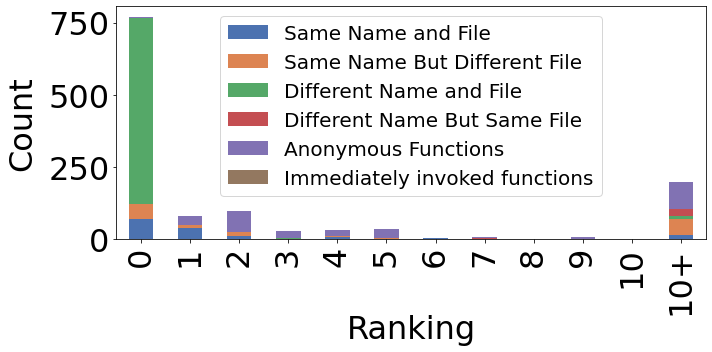

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax1 = plt.subplots()
sns.set_palette("deep")
line_styles = ['solid', 'dashed', 'dashdot', 'dotted']
markers = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D',
           '|', '_', 'd', '8', ',', '.', 'o', 'v', '^', '<', '>']

count_dataframe.set_index('category').plot(kind='bar', stacked=True, ax=ax1)
# dynamic_count_dataframe.set_index('category').plot(kind='bar', stacked=True, ax=ax1)
# for lines, marker, legend_handle in zip(ax1.lines[::-1], markers, ax1.legend_.legendHandles):
#     lines.set_marker(marker)
    
plt.xticks(range(len(xticks_list)), xticks_list)
# plt.legend(ncol=3)

xticks_list=[]
categories =[x for x in range(ranking_count+1)]
for x in range(ranking_count+1):
    xticks_list.append(str(x))
xticks_list.append(str(ranking_count)+'+')

plt.xticks(range(len(xticks_list)), xticks_list)
yticks_list=['0','250','500','750']
yticks = [0,250,500,750]
plt.yticks(yticks, yticks_list)
plt.xlabel('Ranking')
plt.ylabel('Proportion')
plt.subplots_adjust(top = 0.99, bottom = 0.2, right = 0.95, left = 0.05, 
            hspace = 0, wspace = 0)
fs=32
font_size = 20
plt.ylabel("Count", fontsize=fs, labelpad=10)
plt.xlabel("Ranking", fontsize=fs, labelpad=0)
ax1.legend(prop={'size':font_size})
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='y', which='major', labelsize=fs)
plt.tick_params(axis='x', which='major', labelsize=fs, rotation=90)
plt.rcParams["figure.figsize"] = (10, 5)
plt.tight_layout()
plt.savefig("candidate_figures/stacked_bar_comparison_"+APPLICATION_NAME+".pdf")
# plt.savefig("transfer_learning.pdf",bbox_inches='tight', pad_inches=0, transparent=True)
# plt.savefig("candidate_figures/stacked_bar"+APPLICATION_NAME+".pdf")

In [33]:
def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    import matplotlib.pyplot as plt
    import seaborn as sns
    fig, ax1 = plt.subplots()

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar", linewidth=0, stacked=True, ax=ax1, legend=False, grid=False, **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    # axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    # axe.set_xticklabels(df.index, rotation = 0)
    # axe.set_title(title)

    # Add invisible data to add another legend
    fs=28
    font_size = 18
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[1:n_col-1], l[1:n_col-1], loc='upper right', prop={'size':font_size})
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[0.08,.7], prop={'size':font_size}) 
    axe.add_artist(l1)
    
    xticks_list=[]
    categories =[x for x in range(ranking_count+1)]
    for x in range(ranking_count+1):
        xticks_list.append(str(x))
    xticks_list.append(str(ranking_count)+'+')
    
    plt.xticks(range(len(xticks_list)), xticks_list)
    plt.xlabel('Ranking')
    plt.ylabel('Proportion')
    plt.subplots_adjust(top = 0.99, bottom = 0.2, right = 0.95, left = 0.05, 
                hspace = 0, wspace = 0)
    
    plt.ylabel("Count", fontsize=fs, labelpad=10)
    plt.xlabel("Ranking", fontsize=fs, labelpad=0)
    # ax1.legend(app_list,prop={'size':font_size})
    plt.tick_params(axis='both', which='major')
    plt.tick_params(axis='y', which='major', labelsize=fs)
    plt.tick_params(axis='x', which='major', labelsize=fs, rotation=0)
    plt.rcParams["figure.figsize"] = (10, 5)
    plt.tight_layout()
    plt.savefig("candidate_figures/stacked_bar_comparison_"+APPLICATION_NAME+".pdf")
    # plt.show()

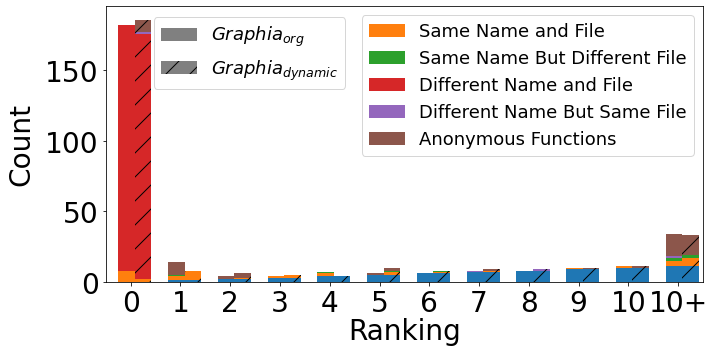

In [34]:
plot_clustered_stacked([count_dataframe, dynamic_count_dataframe],["$Graphia_{org}$", "$Graphia_{dynamic}$"])

<AxesSubplot:title={'center':'multiple stacked bar plot'}>

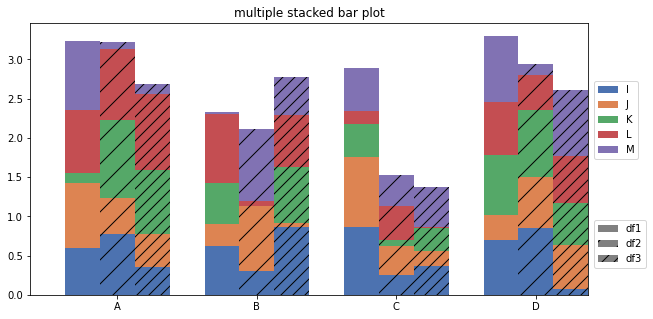

In [ ]:
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

# def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
#     """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
# labels is a list of the names of the dataframe, used for the legend
# title is a string for the title of the plot
# H is the hatch used for identification of the different dataframe"""

#     n_df = len(dfall)
#     n_col = len(dfall[0].columns) 
#     n_ind = len(dfall[0].index)
#     axe = plt.subplot(111)

#     for df in dfall : # for each data frame
#         axe = df.plot(kind="bar",
#                       linewidth=0,
#                       stacked=True,
#                       ax=axe,
#                       legend=False,
#                       grid=False,
#                       **kwargs)  # make bar plots

#     h,l = axe.get_legend_handles_labels() # get the handles we want to modify
#     for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
#         for j, pa in enumerate(h[i:i+n_col]):
#             for rect in pa.patches: # for each index
#                 rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
#                 rect.set_hatch(H * int(i / n_col)) #edited part     
#                 rect.set_width(1 / float(n_df + 1))

#     axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
#     axe.set_xticklabels(df.index, rotation = 0)
#     axe.set_title(title)

#     # Add invisible data to add another legend
#     n=[]        
#     for i in range(n_df):
#         n.append(axe.bar(0, 0, color="gray", hatch=H * i))

#     l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
#     if labels is not None:
#         l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
#     axe.add_artist(l1)
#     return axe

# create fake dataframes
df1 = pd.DataFrame(np.random.rand(4, 5),
                   index=["A", "B", "C", "D"],
                   columns=["I", "J", "K", "L", "M"])
df2 = pd.DataFrame(np.random.rand(4, 5),
                   index=["A", "B", "C", "D"],
                   columns=["I", "J", "K", "L", "M"])
df3 = pd.DataFrame(np.random.rand(4, 5),
                   index=["A", "B", "C", "D"], 
                   columns=["I", "J", "K", "L", "M"])

# Then, just call :
plot_clustered_stacked([df1, df2, df3],["df1", "df2", "df3"])

<AxesSubplot:title={'center':'multiple stacked bar plot'}>

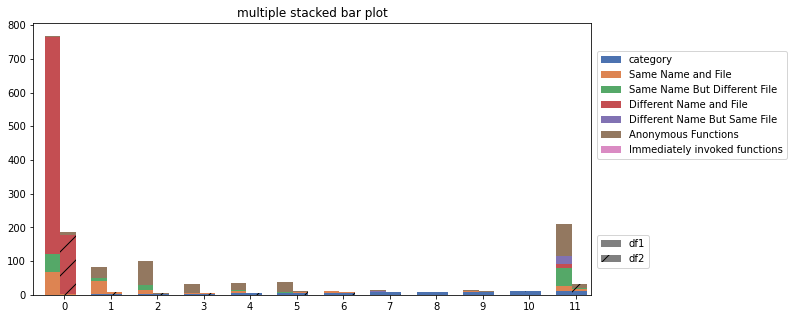

In [ ]:
plot_clustered_stacked([count_dataframe, dynamic_count_dataframe],["df1", "df2"])

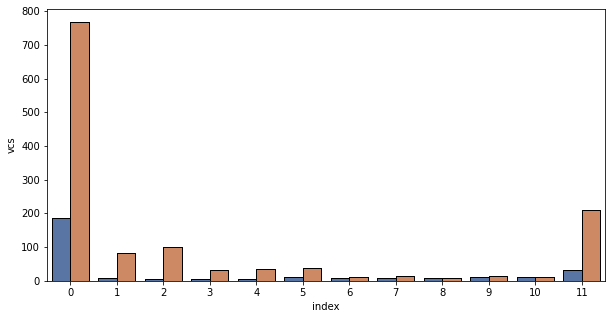

In [ ]:
df1 = dynamic_count_dataframe
df2 = count_dataframe
df1["Name"] = "df1"
df2["Name"] = "df2"
dfall = pd.concat([pd.melt(i.reset_index(),
                           id_vars=["Name", "index"]) # transform in tidy format each df
                   for i in [df1, df2]],
                   ignore_index=True)

dfall.set_index(["Name", "index", "variable"], inplace=True)
dfall["vcs"] = dfall.groupby(level=["Name", "index"]).cumsum()
dfall.reset_index(inplace=True) 

# c = ["blue", "purple", "red", "green", "pink"]
for i, g in enumerate(dfall.groupby("variable")):
    ax = sns.barplot(data=g[1],
                     x="index",
                     y="vcs",
                     hue="Name",
                     zorder=-i, # so first bars stay on top
                     edgecolor="k")
ax.legend_.remove() # remove the redundant legends